In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import arviz as az
import pymc3 as pm
import theano.tensor as tt
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [2]:
# Read the data
howell1 = pd.read_csv('../Data/Howell1.csv',sep=';')

# Normalize the age column
howell1['age'] = StandardScaler().fit_transform(howell1['age'].values.reshape(-1,1))

# Divide dataframe into two equal
d1, d2 = train_test_split(howell1, test_size=0.5, random_state=42)

In [3]:
d1.describe()

,height,weight,age,male
count,272.000000,272.000000,272.000000,272.000000
mean,139.846248,36.518423,-0.007330,0.459559
std,26.206521,14.259042,0.981193,0.499280
min,55.880000,4.847764,-1.415702,0.000000
25%,130.340100,24.408919,-0.788525,0.000000
50%,149.225000,41.276872,-0.161348,0.000000
75%,157.638750,47.520849,0.610562,1.000000
max,172.999400,58.825212,2.829802,1.000000


## Polynomial models

In [4]:
from sklearn.preprocessing import PolynomialFeatures
import pickle
from scipy.stats import norm
from scipy.special import logsumexp

def pickle_model(output_path: str, model, trace):
    """Pickles PyMC3 model and trace"""
    with open(output_path, "wb") as buff:
        pickle.dump({"model": model, "trace": trace}, buff)
        
def sample_polynomial_regressions(d1, xcol, ycol, degree=1, weak_prior=True):

    yval = d1[ycol].values
    # Polynomial features
    polynomial_features= PolynomialFeatures(degree=degree, include_bias=False)
    xval = polynomial_features.fit_transform(d1[xcol].values.reshape(-1,1))
    
    with pm.Model() as model_1:
        a = pm.Normal('a', mu=10, sigma=10)
        if weak_prior:
            b = pm.Normal('b', mu=0, sigma=100, shape=(degree))
        else:
            b = pm.Normal('b', mu=0, sigma=5, shape=(degree))
        sigma = pm.Uniform('sigma', lower=0, upper=10)
        mu = pm.Deterministic('mu', a + tt.dot(xval,b))
        h = pm.Normal('h', mu=mu, sigma=sigma, observed=yval)
        trace_1 = pm.sample(cores=2)
    
    if weak_prior:
        model_1.name = 'M%d_weak' % degree
    else:
        model_1.name = 'M%d_string' % degree
    pickle_model('polynomial_model_degree_%d.pkl' % degree, model_1, trace_1)
    return model_1,trace_1

In [5]:
M6_weak,trace6_weak = sample_polynomial_regressions(d1, xcol='age', ycol='height',degree=6, weak_prior=True)
M6_strong,trace6_strong = sample_polynomial_regressions(d1, xcol='age', ycol='height',degree=6, weak_prior=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains, 1 divergences: 100%|██████████| 2000/2000 [01:37<00:00, 20.53draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [01:18<00:00, 25.50draws/s]
The acceptance probability does not match the target. It is 0.8887239704356314, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [6]:
def compute_WAIC_general(d1,trace):
    
    #yi
    yi = d1['height'].values

    # mu
    degree = trace['b'].shape[1]
    polynomial_features= PolynomialFeatures(degree=degree, include_bias=False)
    xi = polynomial_features.fit_transform(d1['age'].values.reshape(-1,1))
    a = trace['a'][:,np.newaxis]
    b = trace['b']
    mu = a + np.dot(b,xi.T)
    
    #sigma
    sigma = trace['sigma'] 
    
    # Make a nsamples X nobs log-liklihoods matrix
    loglik = np.zeros(mu.shape)
    nsamples = mu.shape[0]
    nobs = mu.shape[1]
    for i in range(nsamples):
        loglik[i,:] = norm.logpdf(yi.ravel(), loc=mu[i,:].ravel(), scale=sigma[i])
    
    # compute lppd
    lppd = np.zeros((nobs,1))
    for i in range(nobs):
        lppd[i] = logsumexp(loglik[:,i]) - np.log(nsamples)
    
    # computing pwaic
    pwaic = np.zeros((nobs,1))
    for i in range(nobs):
        pwaic[i] = np.var(loglik[:,i])
    
    # finally compute WAIC
    waic = -2*(np.sum(lppd) - np.sum(pwaic))
    return waic

def compare_models_waic(waic):
    
    df_waic = pd.DataFrame.from_dict(waic, orient='index')
    df_waic.columns = ['WAIC']
    df_waic['dWAIC'] = df_waic['WAIC'] - df_waic['WAIC'].min()
    df_waic = df_waic.sort_values(by='dWAIC')

    df_waic['weight'] = np.exp(-0.5*df_waic['dWAIC'])
    df_waic['weight'] = df_waic['weight']/df_waic['weight'].sum()
    return df_waic

In [10]:
# Deviance in d1
waic_d1 = {'M6_weak':compute_WAIC_general(d1,trace6_weak),
       'M6_strong':compute_WAIC_general(d1,trace6_strong)}
df_waic_d1 = compare_models_waic(waic_d1)
print(df_waic_d1)

# using pymc3 funcition
pm.compare({M6_weak:trace6_weak,M6_strong:trace6_strong})

                  WAIC     dWAIC   weight
M6_weak    1908.425912  0.000000  0.89239
M6_strong  1912.656684  4.230772  0.10761


/home/amit/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
<pymc3.model.Model object at 0x7fdf28cd8890>,0,1908.43,7.15844,0,0.828299,22.6619,0,True,deviance
<pymc3.model.Model object at 0x7fdf1e5db890>,1,1912.66,6.47605,4.23077,0.171701,23.0405,2.99223,True,deviance


In [8]:
# test-sample Deviance in d2
waic_d2 = {'M6_weak':compute_WAIC_general(d2,trace6_weak),
       'M6_strong':compute_WAIC_general(d2,trace6_strong)}
df_waic_d2 = compare_models_waic(waic_d2)
df_waic_d2

,WAIC,dWAIC,weight
M6_weak,1911.634712,0.000000,0.840315
M6_strong,1914.955861,3.321148,0.159685


## Compare the WAIC estimates from d1 and d2

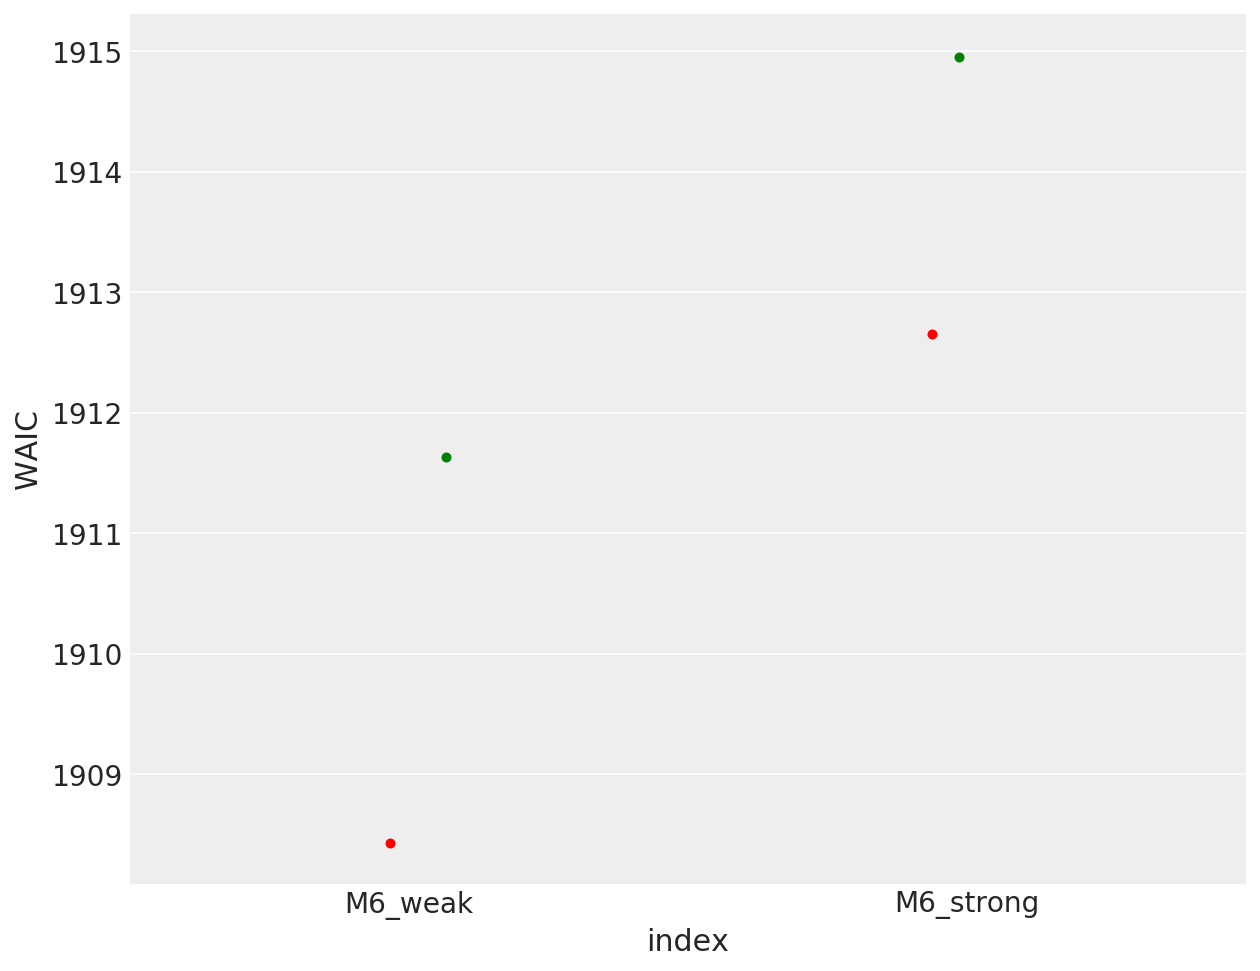

In [9]:
fig,ax = plt.subplots(figsize=(10,8))
g=sns.catplot(y='WAIC',data=df_waic_d1.reset_index(),x='index',label='d1',ax=ax,color='r')
h=sns.catplot(y='WAIC',data=df_waic_d2.reset_index(),x='index',label='d2',ax=ax,color='g')
plt.close(g.fig)
plt.close(h.fig)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[5:7], labels[5:7])